In [1]:
import os
PROJECT_ID = "wscc-dev-app-wsky" # @param {type:"string"}
LOCATION = "us-central1" # @param {type:"string"}
REGION = "us-central1"

In [2]:
! gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=XROFUmAmr514Aap7kpx21ojveoDwOO&access_type=offline&code_challenge=_h56b9JKNYNplk6j1rntl-NKGIPTewglM8LTiiVTO14&code_challenge_method=S256


Credentials saved to file: [/Users/vkoova/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "wscc-dev-app-wsky" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the 

In [3]:
# Initialize Vertex AI
import vertexai
vertexai.init(project=PROJECT_ID, location=LOCATION)

from google.cloud import aiplatform
aiplatform.init(project=PROJECT_ID, location=REGION)

In [4]:
# Utils
import time
from typing import List

# Langchain
import langchain
from pydantic import BaseModel

print(f"LangChain version: {langchain.__version__}")

# Vertex AI
from google.cloud import aiplatform
from langchain.chat_models import ChatVertexAI
from langchain.embeddings import VertexAIEmbeddings
from langchain.llms import VertexAI
from langchain.schema import HumanMessage, SystemMessage

print(f"Vertex AI SDK version: {aiplatform.__version__}")

LangChain version: 0.0.229
Vertex AI SDK version: 1.33.1


In [5]:
# Utility functions for Embeddings API with rate limiting
def rate_limit(max_per_minute):
    period = 60 / max_per_minute
    print("Waiting")
    while True:
        before = time.time()
        yield
        after = time.time()
        elapsed = after - before
        sleep_time = max(0, period - elapsed)
        if sleep_time > 0:
            print(".", end="")
            time.sleep(sleep_time)


class CustomVertexAIEmbeddings(VertexAIEmbeddings, BaseModel):
    requests_per_minute: int
    num_instances_per_batch: int

    # Overriding embed_documents method
    def embed_documents(self, texts: List[str]):
        limiter = rate_limit(self.requests_per_minute)
        results = []
        docs = list(texts)

        while docs:
            # Working in batches because the API accepts maximum 5
            # documents per request to get embeddings
            head, docs = (
                docs[: self.num_instances_per_batch],
                docs[self.num_instances_per_batch :],
            )
            chunk = self.client.get_embeddings(head)
            results.extend(chunk)
            next(limiter)

        return [r.values for r in results]

In [6]:
# LLM model
llm = VertexAI(
    model_name="text-bison@001",
    max_output_tokens=256,
    temperature=0.1,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

# Chat
chat = ChatVertexAI(project=PROJECT_ID, location=LOCATION)

# Embedding
EMBEDDING_QPM = 100
EMBEDDING_NUM_BATCH = 5
embeddings = CustomVertexAIEmbeddings(
    requests_per_minute=EMBEDDING_QPM,
    num_instances_per_batch=EMBEDDING_NUM_BATCH,
)

In [7]:
import os
from google.cloud import vision
from google.cloud.vision_v1 import types

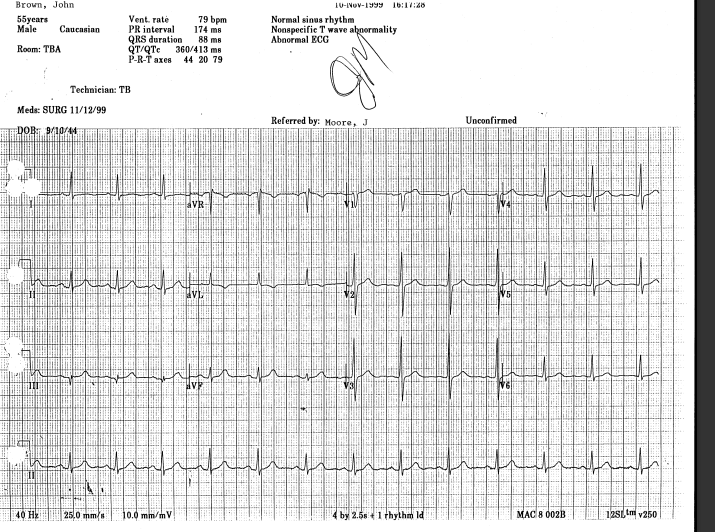

In [8]:
from PIL import Image
image  = Image.open("./image-3.png").convert("RGB")
image

# Make sure to update the link for the image we are calling.For our demo above, we are calling the input source image from the drive.

In [9]:

import io

# Initialize the Vision API client
client = vision.ImageAnnotatorClient()

# Define the path to your image file (or provide a URL)
image_path = './image-3.png'

# Make sure to update the link for the image we are calling.For our demo above, we are calling the input source image from the drive.

# Read the image file
with io.open(image_path, 'rb') as image_file:
    content = image_file.read()

# Create an image object
image = vision.Image(content=content)

# Use the Text Detection feature to extract text
response = client.text_detection(image=image)
text = response.full_text_annotation.text

# Print the extracted text
print(text)

Brown, John
55years
Male
Room: TBA
Caucasian
40 H
Meds: SURG 11/12/99
DOBE 9/10/
Technician: TB
Vent. raté
PR interval
QRS duration
QT/QTc
P-R-Taxes
250 mm
19 bpm
114 ms
88 ms
360/413 m
44 20 79
مسيلت
بالله النت
aVR-
10.0 mm/m
IVE
السيلية السيل
1-Nov-1999 10:11:48
Normal sinus rhythm
Nonspecific T wave abnormality
Abnormal ECG
Referred by: Moore, J
السياسة الاساسياسيلي السلسلة
Unconfirmed
4 by 2.5s 1 rhythm Id
:
MAC B 00213
12SLtm v250


In [10]:
# text_embedding = embeddings.embed_query(text)
# loader = text
# documents = loader

In [11]:

# split the documents into chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=0)
docs = text_splitter.split_text(text)
print(f"# of documents = {len(docs)}")

# of documents = 1


In [12]:
embeddings

CustomVertexAIEmbeddings(client=<vertexai.preview.language_models._PreviewTextEmbeddingModel object at 0x12914acd0>, model_name='textembedding-gecko', temperature=0.0, max_output_tokens=128, top_p=0.95, top_k=40, stop=None, project=None, location='us-central1', credentials=None, request_parallelism=5, max_retries=6, requests_per_minute=100, num_instances_per_batch=5)

In [13]:
# Store docs in local vectorstore as index
# it may take a while since API is rate limited
from langchain.vectorstores import Chroma

db = Chroma.from_texts(docs, embeddings)

# Sometimes we might get error for the panda version. We can ignore and try to re-run this command multiple times.

Waiting


In [14]:
# Expose index to the retriever
retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 2})

In [15]:

# Create chain to answer questions
from langchain.chains import RetrievalQA

# Uses LLM to synthesize results from the search index.
# We use Vertex PaLM Text API for LLM
qa = RetrievalQA.from_chain_type(
    llm=llm, chain_type="stuff", retriever=retriever, return_source_documents=True
)

In [16]:
query = "What is the image about?"
result = qa({"query": query})
print(result)

Number of requested results 2 is greater than number of elements in index 1, updating n_results = 1


{'query': 'What is the image about?', 'result': 'The image is about an electrocardiogram (ECG) of a patient named Brown, John. The ECG shows that the patient has a normal sinus rhythm, but there is a nonspecific T wave abnormality. This abnormality is not considered to be a serious problem, but it may be worth monitoring in case it becomes more severe.', 'source_documents': [Document(page_content='Brown, John\n55years\nMale\nRoom: TBA\nCaucasian\n40 H\nMeds: SURG 11/12/99\nDOBE 9/10/\nTechnician: TB\nVent. raté\nPR interval\nQRS duration\nQT/QTc\nP-R-Taxes\n250 mm\n19 bpm\n114 ms\n88 ms\n360/413 m\n44 20 79\nمسيلت\nبالله النت\naVR-\n10.0 mm/m\nIVE\nالسيلية السيل\n1-Nov-1999 10:11:48\nNormal sinus rhythm\nNonspecific T wave abnormality\nAbnormal ECG\nReferred by: Moore, J\nالسياسة الاساسياسيلي السلسلة\nUnconfirmed\n4 by 2.5s 1 rhythm Id\n:\nMAC B 00213\n12SLtm v250', metadata={})]}


In [17]:
query = "What is the diagnosis?"
result = qa({"query": query})
print(result)

Number of requested results 2 is greater than number of elements in index 1, updating n_results = 1


{'query': 'What is the diagnosis?', 'result': 'The diagnosis is Normal sinus rhythm.', 'source_documents': [Document(page_content='Brown, John\n55years\nMale\nRoom: TBA\nCaucasian\n40 H\nMeds: SURG 11/12/99\nDOBE 9/10/\nTechnician: TB\nVent. raté\nPR interval\nQRS duration\nQT/QTc\nP-R-Taxes\n250 mm\n19 bpm\n114 ms\n88 ms\n360/413 m\n44 20 79\nمسيلت\nبالله النت\naVR-\n10.0 mm/m\nIVE\nالسيلية السيل\n1-Nov-1999 10:11:48\nNormal sinus rhythm\nNonspecific T wave abnormality\nAbnormal ECG\nReferred by: Moore, J\nالسياسة الاساسياسيلي السلسلة\nUnconfirmed\n4 by 2.5s 1 rhythm Id\n:\nMAC B 00213\n12SLtm v250', metadata={})]}
